# Public Data Collection Exploration - ESA Global Land Cover 

In [1]:
# Sentinel Hub
from sentinelhub import (
    SHConfig, DataCollection, Geometry, BBox, CRS,
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType,
    SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
    DownloadFailedException
)

In [2]:
creodias_config = SHConfig()
creodias_config.sh_base_url = 'https://creodias.sentinel-hub.com'

In [3]:
byoc = DataCollection.define(
        name='Global Land Cover',
        api_id='byoc-f0a97620-0e88-4c1f-a1ac-bb388fabdf2c',  #Type
        catalog_id='f0a97620-0e88-4c1f-a1ac-bb388fabdf2c', # collection_id
        service_url='https://creodias.sentinel-hub.com', # End point
        is_timeless=False
    )
byoc

<DataCollection.Global Land Cover: DataCollectionDefinition(
  api_id: byoc-f0a97620-0e88-4c1f-a1ac-bb388fabdf2c
  catalog_id: f0a97620-0e88-4c1f-a1ac-bb388fabdf2c
  service_url: https://creodias.sentinel-hub.com
  is_timeless: False
  has_cloud_coverage: False
)>

In [4]:
from sentinelhub import bbox_to_dimensions

bbox = BBox([-3, 51.0, -1, 52], crs=CRS.WGS84)
aoi = bbox_to_dimensions( bbox, resolution=1000)

evalscript_byoc = """
//VERSION=3
function setup() {
  return {
    input: [ { bands: [ "Discrete_Classification_map",
                         "Bare_CoverFraction_layer",
                         "BuiltUp_CoverFraction_layer",
                         "Crops_CoverFraction_layer",
                         "Grass_CoverFraction_layer",
                         "MossLichen_CoverFraction_layer",
                         "Shrub_CoverFraction_layer",
                         "Tree_CoverFraction_layer",
                         "PermanentWater_CoverFraction_layer",
                         "SeasonalWater_CoverFraction_layer",
                         "Change_Confidence_layer" ],
                units: ["DN", "DN", "DN", "DN", "DN", "DN", "DN", "DN", "DN", "DN", "DN" ] 
            }],
    output: { bands: 11, sampleType: SampleType.UINT16  }
  };
}
function evaluatePixel(sample) {
  return [ sample.Discrete_Classification_map,
           sample.Bare_CoverFraction_layer,
           sample.BuiltUp_CoverFraction_layer,
           sample.Crops_CoverFraction_layer,
           sample.Grass_CoverFraction_layer,
           sample.MossLichen_CoverFraction_layer,
           sample.Shrub_CoverFraction_layer,
           sample.Tree_CoverFraction_layer,
           sample.PermanentWater_CoverFraction_layer,
           sample.SeasonalWater_CoverFraction_layer,
           sample.Change_Confidence_layer,           
           ];
}
"""

byoc_request = SentinelHubRequest(
    evalscript=evalscript_byoc,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=byoc,
            time_interval=('2016-01-01', '2020-12-01'),
        )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=aoi,
    config=creodias_config
)

byoc_data = byoc_request.get_data()
byoc_data

[array([[[ 30,   0,   0, ...,   0,   0,   0],
         [ 30,   0,   0, ...,   0,   0,   0],
         [ 30,   0,   0, ...,   0,   0,   0],
         ...,
         [ 40,   1,   0, ...,   0,   0,   0],
         [ 30,   0,   0, ...,   0,   0,   0],
         [ 40,   0,   0, ...,   0,   0,   0]],
 
        [[ 30,   0,   0, ...,   0,   0,   0],
         [ 30,   0,   0, ...,   0,   0,   0],
         [ 30,   0,   0, ...,   0,   0,   0],
         ...,
         [ 30,   0,   0, ...,   0,   0,   0],
         [ 40,   0,   0, ...,   0,   0,   0],
         [ 40,   2,   0, ...,   0,   0,   0]],
 
        [[ 30,   0,   0, ...,   0,   0,   0],
         [ 30,   0,   0, ...,   0,   0,   0],
         [ 30,   0,  15, ...,   0,   0,   0],
         ...,
         [ 40,   0,   0, ...,   0,   0,   0],
         [ 40,   0,   0, ...,   0,   0,   0],
         [ 40,   0,   0, ...,   0,   0,   0]],
 
        ...,
 
        [[ 40,   0,  20, ...,   0,   0,   0],
         [ 40,   0,   0, ...,   0,   0,   0],
         [126,

In [5]:
from datetime import datetime, timedelta
from sentinelhub import SentinelHubCatalog


# get catalog for collection
catalog = SentinelHubCatalog(
    base_url=byoc.service_url,
    config=creodias_config
)


timeframe = '2016-01-01T00:00:00Z', '2021-12-01T00:00:00Z'


# execute search
iterator = catalog.search (
            byoc,
            bbox=bbox,
            time=timeframe,
)

# filter timestamps into +- 1 hour groupings
timestamps = iterator.get_timestamps()
timestamps = filter_times( timestamps, timedelta(hours=1) )
timestamps

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\sentinelhub\sh_utils.py:90: SHDeprecationWarning: Parameter base_url is deprecated and will soon be removed. Instead set config.sh_base_url = base_url and provide it with config parameter
  warnings.warn('Parameter base_url is deprecated and will soon be removed. Instead set '


[datetime.datetime(2016, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2019, 1, 1, 0, 0, tzinfo=tzutc())]

### _Repeat analysis using Sentinel-Hub client class_

In [6]:
import os

# define repo name and get root working directory
repo = 'process-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api'

In [7]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'public' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api\\cfg\\public'

In [8]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 'global-land-cover.yml' )

In [9]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [ { bands: [ "Discrete_Classification_map",
                                            "Bare_CoverFraction_layer",
                                            "BuiltUp_CoverFraction_layer",
                                            "Crops_CoverFraction_layer",
                                            "Grass_CoverFraction_layer",
                                            "MossLichen_CoverFraction_layer",
                                            "Shrub_CoverFraction_layer",
                                            "Tree_CoverFraction_layer",
                                            "PermanentWater_CoverFraction_layer",
                                            "SeasonalWater_CoverFraction_layer",
                                            "Change_Confidence_layer" ],
                                units: ["DN", "DN", "D

In [10]:
import yaml
from munch import munchify

# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [11]:
from processapi import Client
client = Client( config, base_url='https://creodias.sentinel-hub.com' )

In [12]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2019, 1, 1, 0, 0, 0 ), 
                'end' : datetime( 2020, 12, 31, 23, 59, 59 ) }


In [13]:
coords = [ -3, 51.0, -2, 52 ]
bbox = client.getBoundingBox( coords )

resolution=50

In [14]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1373, 2234)

In [15]:
# get S2 acquisitions between start / end dates satisfying filter conditions
timestamps = client.getDatasetTimeStamps ( config.request.inputs[ 0 ], bbox, timeframe )
timestamps

[datetime.datetime(2019, 1, 1, 0, 0, tzinfo=tzutc())]

In [16]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution=resolution )
response._df

,default,time
0,"[[[126, 0, 32, 27, 35, 0, 0, 6, 0, 0, 0], [30,...",2019-01-01 00:00:00+00:00


### _Visualise land cover classification output_

In [17]:
response._df.iloc[ 0 ][ 'default' ][ :, :, 0 ]

array([[126,  30,  30, ..., 126, 126,  40],
       [126,  30,  30, ..., 126, 126,  40],
       [126,  30,  30, ...,  30,  30,  30],
       ...,
       [ 40, 126, 126, ...,  40,  40,  40],
       [ 40, 126, 126, ..., 116, 125, 125],
       [ 40, 126, 126, ..., 116, 125, 125]], dtype=uint16)

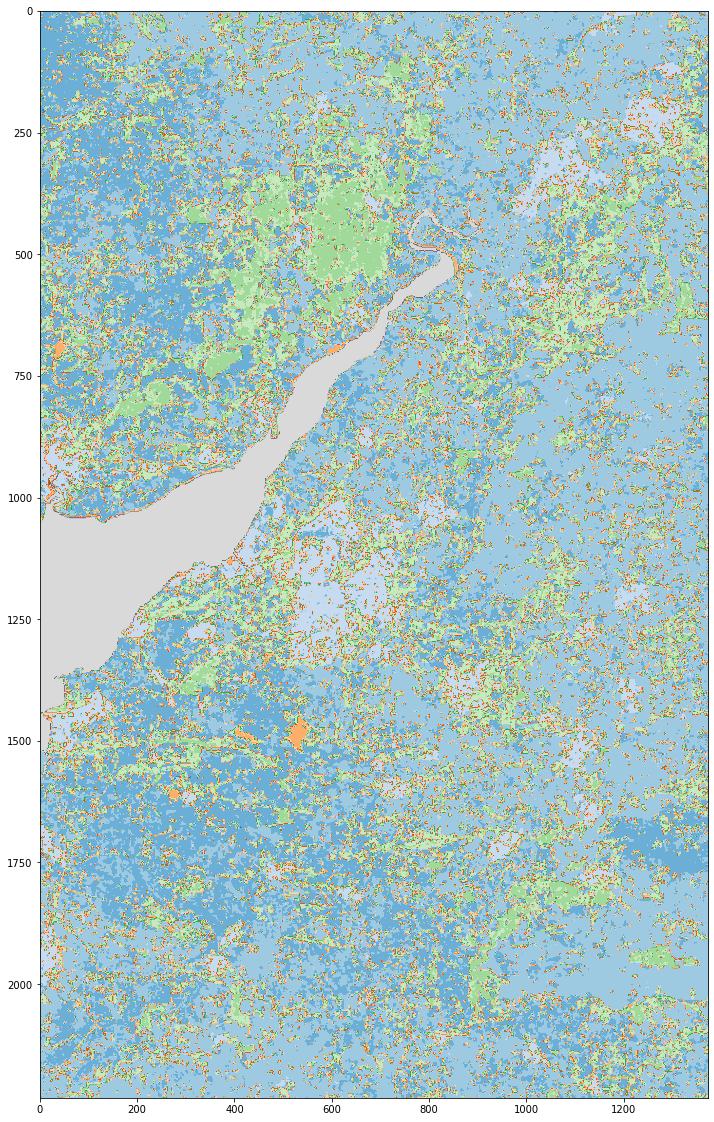

In [18]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots( figsize=(20,20))
ax.imshow( response._df.iloc[ 0 ][ 'default' ][ :, :, 0 ], cmap='tab20c' )

### _Create binary mask mapping forest land cover classes_

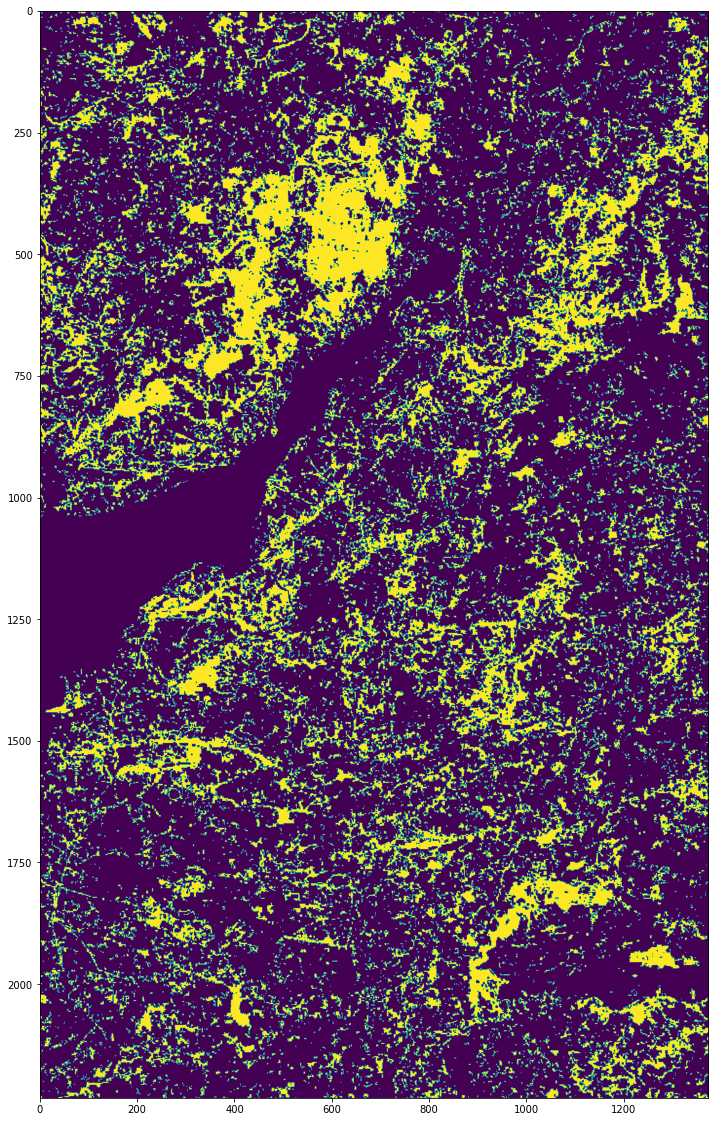

In [19]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots( figsize=(20,20))
ax.imshow( ( response._df.iloc[ 0 ][ 'default' ][ :, :, 0 ] >= 111 ) & ( response._df.iloc[ 0 ][ 'default' ][ :, :, 0 ] <= 126 ) )